In [2]:
import tensorflow as tf
import utils
import train
import samplers
import models
import inpaint
import visualize
import absl
import numpy as np
import absl
import matplotlib.pyplot as plt

## Train models

In [3]:
EPOCHS = 1

### Train VAE

Loss=171.116: 100%|██████████| 1/1 [00:15<00:00, 15.73s/it]


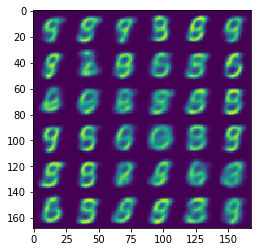

In [4]:
data_path  = '../../data/mnist.npy'
model_spec = '../model_specs/vae_mnist.json'
model = train.train(data_path, model_spec, epochs=EPOCHS)
model.plot_sample()

### Train GAN

In [6]:
data_path  = '../../data/mnist.npy'
model_spec = '../model_specs/gan_mnist.json'
model = train.train(data_path, model_spec, epochs=10)
model.plot_sample()

Loss - Discriminator: -0.9617627859115601, Generator: 0.2944957911968231, Gradient Penalty: 0.4306778311729431:  10%|█         | 1/10 [02:40<12:24, 82.67s/it]  ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-99ab32c77f24>", line 3, in <module>
    model = train.train(data_path, model_spec, epochs=10)
  File "/home/jovyan/terrain_dgm/dgm-backend/dgm-backend/train.py", line 58, in train
    model.train(dataset)
  File "/home/jovyan/terrain_dgm/dgm-backend/dgm-backend/models.py", line 115, in train
    if self.D_optimizer.iterations.numpy() % self.spec['gen_train_steps']== 0:
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py", line 582, in numpy
    return self.read_value().numpy()
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 942, in numpy
    maybe_arr = self._numpy()  # pylint: disable=protected-access
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framewor

KeyboardInterrupt: 

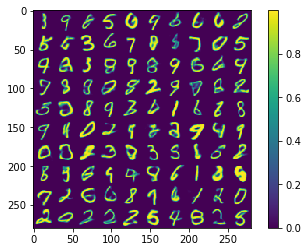

In [7]:
apply_sigmoid = True

generator = tf.keras.models.load_model('../data/saved_models/vae_generative_net.h5')
z = np.random.randn(100,model.latent_dim)
x = model.decode(z)
if apply_sigmoid:
    x = tf.sigmoid(x).numpy()
else:
    x = x.numpy()
x_flat = utils.flatten_image_batch(x.squeeze(),10,10)
plt.imshow(x_flat)
plt.colorbar();

## Inpaint with Langevin dynamics

In [8]:
absl.app.flags.DEFINE_string('f', '', 'kernel')

In [2]:
gen_path = '../data/saved_models/gan_basic_generative_net.h5'
test_path = '../data/datasets/test/mnist_single.npy'
inpaint_spec_path = '../inpaint_specs/test_spec.json'
samples = inpaint.inpaint(gen_path,inpaint_spec_path,test_path,save=True,iterations=20000,use_metropolis=False,
                          noise_sd=0.1,n_samples=400,noise_decay=1.0)
sample_images = tf.sigmoid(samples).numpy()

Loss: 38.88249206542969:   0%|          | 4/20000 [00:04<6:21:40,  1.15s/it]  ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/func_graph.py", line 978, in func_graph_from_py_func
    func_outputs = python_func(*func_args, **func_kwargs)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/func_graph.py", line 964, in wrapper
    user_requested=True,
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/autograph/impl/api.py", line 565, in converted_call
    result = converted_f(*effective_args, **kwargs)
  File "/tmp/tmpqe9l6yw2.py", line 18, in tf__f
    retval_ = fscope.mark_return_value(ag__.converted_call(_pfor_impl, (loop_fn, iters), dict(parallel_iterations=parallel_iterations), fscope))
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/autograph/impl/api.py", line 406, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/autograph/i

TypeError: can only concatenate str (not "list") to str

In [11]:
gen_path_gan = '../data/saved_models/gan_basic_generative_net.h5'
gen_path_vae = '../data/saved_models/vae_basic_generative_net.h5'

gan = tf.keras.models.load_model(gen_path_gan)
vae = tf.keras.models.load_model(gen_path_vae)

In [13]:
vae.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1568)              79968     
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 14, 14, 128)       65664     
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 28, 28, 1)         577       
Total params: 277,345
Trainable params: 277,345
Non-trainable params: 0
_________________________________________________________________


In [20]:
gan.layers[5]= False

In [12]:
gan.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 256)               13056     
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 6272)              1611904   
_________________________________________________________________
batch_normalization_25 (Batc (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 6272)            

## Save inpainting progress GIF

In [15]:
samples_path= '../data/samples/vae_langevin.npy'
np.save(samples_path,sample_images.squeeze())
visualize.samples2gif(samples_path,'../data/visualizations/vae_langevin.gif',10,10,fps=5)

100%|██████████| 250/250 [00:07<00:00, 31.63it/s]


In [17]:
! chmod 777 ../data/visualizations/

In [5]:
def replace_batch_with_masked(mask_single,image_batch):
    assert len(mask_single.shape) == 4
    assert len(image_batch.shape) == 4
    
    batch_size = image_batch.shape[0]
    
    # This array is zero for all pixels that are to be replaced
    # Pixels are replaced if their mask is zero in the original
    # masked array
    is_kept = np.repeat(mask_single.mask,batch_size , axis=0)
    
    # Zero out all the pixels that are NOT masked in the test data
    new_batch = image_batch * is_kept
    
    single_with_zeros = mask_single.data * (1-mask_single.mask)
    repeated_single = np.repeat(single_with_zeros,batch_size,axis=0)
    return new_batch + repeated_single

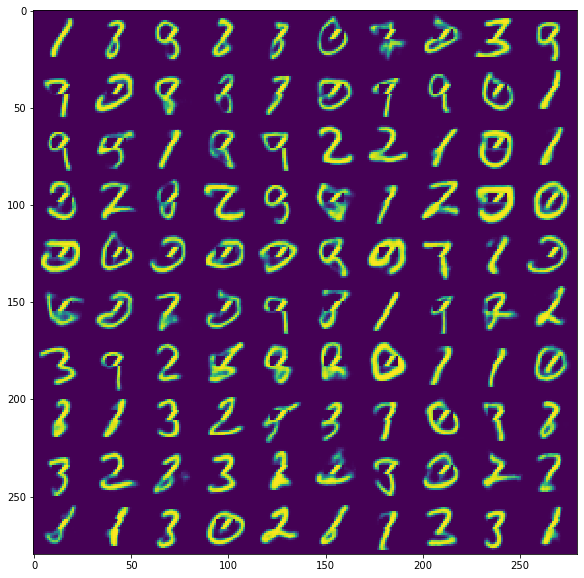

In [7]:
masked_image = np.load(test_path,allow_pickle=True)
batch = sample_images[-1,:,...]

replaced = replace_batch_with_masked(masked_image,batch)
plt.figure(figsize=(10,10))
plt.imshow(utils.flatten_image_batch(replaced,10,10))

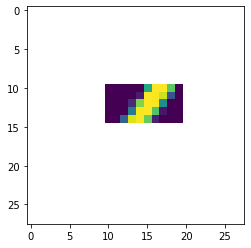

In [15]:
plt.imshow(np.squeeze(np.load(test_path,allow_pickle=True)))

In [4]:
x = tf.sigmoid(samples).numpy()

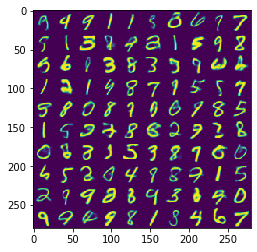

In [5]:
import matplotlib.pyplot as plt
plt.imshow(utils.flatten_image_batch(x[-1],10,10))

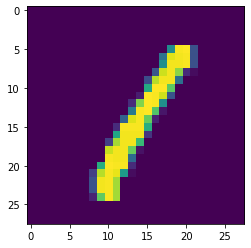

In [6]:
data = np.load('../../data/mnist.npy')
test_path =  '../data/datasets/test/mnist_single.npy'
single = utils.norm_zero_one(data[3:4])
plt.imshow(single.squeeze())
mask = np.ones_like(single)
mask[:,10:15,10:20,:] = 0
mask_image = np.ma.masked_array(data=single,mask=mask)
plt.imshow(np.squeeze(mask_image))

mask_image.dump(test_path)

(array([695.,   7.,   8.,   4.,   4.,   2.,   4.,   5.,   8.,  47.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

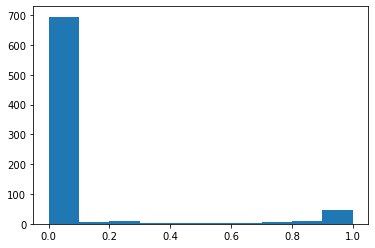

In [7]:
plt.hist(mask_image.data.ravel())

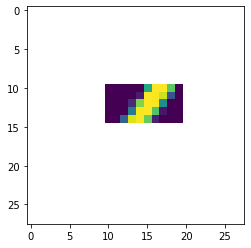

In [8]:
import numpy as np 
test = np.load(test_path, allow_pickle=True)
plt.imshow(np.squeeze(test))

## Tests

In [9]:
def test_vae_train(data_path='../../data/mnist.npy',model_spec = '../model_specs/vae.json'):
    model = train.train(data_path,model_spec,epochs=1)
    
def test_gan_train(data_path='../../data/mnist.npy',model_spec = '../model_specs/gan.json'):
    model = train.train(data_path,model_spec,epochs=1)
    
def check_json_specs(root_dir='..'):
    utils.check_json_valid(root_dir=root_dir)

tests = [test_vae_train,
        test_gan_train,
        check_json_specs]

[test() for test in tests]

Loss=103.614:   0%|          | 0/1 [00:06<?, ?it/s]

KeyboardInterrupt: 